In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score as kappa

## A. Data Processing
---

### 1.
As a first step we will download the dataset of EDOS. Since this exercise wasn't conducted in Google Colab, the dataset has been downloaded and stored under the ```data/``` folder in the project's directory.

In [2]:
# Read .csv files
gab = pd.read_csv('data/gab_1M_unlabelled.csv')
reddit = pd.read_csv('data/reddit_1M_unlabelled.csv')

curr = gab['text'].str.len() # series data-structure of text length
min_gab, max_gab, avg_gab = curr.min(), curr.max(), curr.mean() # compute min, max, mean of series

curr = reddit['text'].str.len()
min_reddit, max_reddit, avg_reddit = curr.min(), curr.max(), curr.mean()

In [3]:
min_gab, max_gab, avg_gab

(1, 250, 93.44149)

In [4]:
min_reddit, max_reddit, avg_reddit

(1, 250, 95.663112)

We notice that the minimum and maximum lengths of characters for the two datasets are the same and equal to 0 and 250, respectively. The average character count is roughly the same, with reddit averaging 93.4 characters and gab 95.6 characters.

### 2.

In [5]:
# Add source columns
gab['source'] = 'gab'
reddit['source'] = 'reddit'

# Combine the two dataframes into one
unlabeled = pd.concat([gab, reddit])

In [6]:
# Sample
my_sample = unlabeled.sample(n=50, random_state=42)

curr = my_sample['text'].str.len() # series data-structure of text length
min_sample, max_sample, avg_sample = curr.min(), curr.max(), curr.mean() # compute min, max, mean of series

In [7]:
min_sample, max_sample, avg_sample

(4, 240, 93.82)

The minimum character length of our sample is 4, while the maximum 240. The average comment length is 93.8 characters.

### 3.

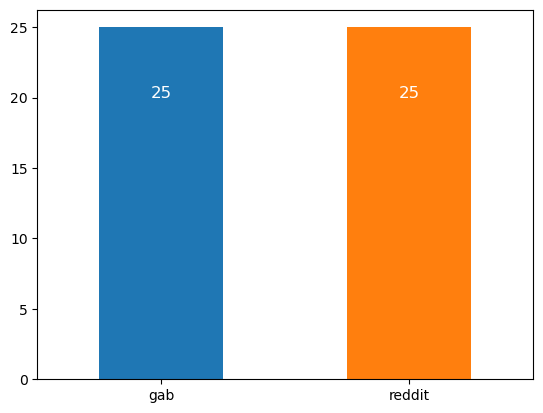

In [8]:
# Plotting sample
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'] # global color list

# sort index, necessary for the data label positioning
plot = my_sample['source'].value_counts().sort_index().plot(kind='bar', rot=0, color=colors)

i = 0 # data label counter
# https://bit.ly/3DteCBO | place value annotations at the center of the bars
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() - 5
    plt.annotate(my_sample['source'].value_counts()[i], xy = (x_value, y_value), ha='center', fontsize=12, color='white')
    i += 1

Our sample happens to be perfectly balanced with 25 entries sourcing from gab and 25 entries sourcing from reddit.

## B. Data Annotation
---

### 1.
As a next step, we will load the ```PDS2022A1_unlabelled_by_KK.csv```, label it as an external data source and merge it with our sample. Once again, the external file was stored under the ```data/input/``` folder of the project's directory.

In [9]:
# Read external .csv file
external = pd.read_csv('data/input/PDS2022A1_unlabelled_by_KK.csv')
external['source'] = 'external' # annotate source

full = pd.concat([my_sample, external]) # merge with sample
full.to_excel('./3352209.xlsx') # store to .xlsx file

## C. Inter-annotator Agreement
---

### 1.
For the following tasks, the ```annotations.zip``` was used. The ```.xlsx``` files included were not uniform regarding their encoding and layout, meaning that not all files followed the 0, 1 encoding for task 1 and 0, 1, 2, 3, 4 encoding for task 2. Furthermore, there were inconsistencies regarding the sheet and column layouts. The files were cleaned with the use of the ```data_cleaning``` notebook that is attached along with this notebook and their corrected versions where stored under the ```data/submissions/``` folder of the project's directory.

The procedure of the cleaning was basically checking the columns and value counts of every different dataframe and column and creating replacement dictionaries that were utilized at the end of the process. In addition, the naming of the files was changed to a uniform format, e.g. ```f#######.xlsx```. It is worth noting that manual changes took place in 2 files (```f3352205.xlsx``` and ```f3352216.xlsx```). These changes included:
- the deletion of a file sheet, so that only one remains active
- the renaming of a task B column from an empty string to B (task B)

Lastly, the gold annotations were stored in the ```data/input/``` folder of the project's directory.

In [10]:
# Create dictionary of dataframes
acc = {} # accumulator
data_dir = "./data/submissions/"
all_files = os.listdir(data_dir) # fetch all files under data/submissions/ directory
for file in all_files:
    df = pd.read_excel(data_dir + file, sheet_name=0) # sheet name for unfilledPossible callees warning
    df = df[['text', 'source', 'A', 'B']] # discard columns other than text, source, A, B
    acc[file.split('.')[0]] = df # student ID as key

acc['f3342208'].head() # example of student's annotation dataset

,text,source,A,B
0,That isn't anywhere in the story. You're grasp...,reddit,0,0
1,we are calling it technoprepping. Move all you...,gab,0,0
2,"""Interactive map of US military incursions out...",gab,0,0
3,"Just FYI, ""water proofing"" isn't a feature you...",gab,0,0
4,"Hi all, can you direct me to where I can join ...",gab,0,0


### 2.

In [11]:
# Load gold annotations
gold = pd.read_excel('./data/input/PDS2022A1_labelled_by_KK.xlsx', sheet_name=0) # sheet name for unfilledPossible callees error
gold.head()

,text,label
0,\tShe's an evil bitch who deserves whatever sh...,1
1,A whore with clearly defined pricing,1
2,"Military wives are often cheating, mooching bi...",1
3,And they are all whores that do anything to ge...,1
4,By the time a bitch sees your dick in person t...,1


We are going to compare the gold annotations against the students' dataframes. To do so, we need to make sure that all involved dataframes are sorted in the same manner, and thus have a 1-1 correspondence between string comments and indexes across all data sources, enabling correct joining. This check is important if we consider the following example:

In [12]:
acc['f3352217'][acc['f3352217']['source'] == 'external'][['text']].sort_values(by=['text']).reset_index(drop=True).head(3)

,text
0,"***""Most whores are just honest women. Most wo..."
1,A fat ugly bitch like that should be grateful ...
2,A modern solution to a modern problem.


In [13]:
acc['f3352218'][acc['f3352218']['source'] == 'external'][['text']].sort_values(by=['text']).reset_index(drop=True).head(3)

,text
0,\tShe's an evil bitch who deserves whatever sh...
1,"***""Most whores are just honest women. Most wo..."
2,A fat ugly bitch like that should be grateful ...


We notice that, if we sort the two datasets by the text column, the comment that starts with ```***``` is assigned an index of 0 in the first dataset and an index of 1 in the second one. This, apparently, is due to leading characters that exist in some datasets, which possibly occurs due to different encoding of the files. This would introduce errors in the potential joining and thus produce false results. We are going to handle that case by stripping comments from leading characters and see if that step is enough to achieve a 1-1 correspondence between indexes and comments.

The following cell carries through that check. It strips leading characters from all comments across students' datasets and checks whether the sorted dataframes are equal, e.g. the tuples (index, text) are equal.

In [14]:
# Ensure 1-1 correspondence between indexes and texts for sorted dataframes
# Gold annotations
gold['text'] = gold['text'].str.lstrip() # remove leading from the left
gold = gold[['text', 'label']].sort_values(by=['text']).reset_index(drop=True) # sort, reset index, save as new

# Students' annotators
f = 0 # flag of 1-1 correspondence
acc_gold = {} # create a new dictionary for task C, with sorted comments and 1-1 correspondence with indexes for students
for key, value in acc.items():
    curr = value # current dataframe
    curr['text'] = curr['text'].str.lstrip() # remove leading from the left
    curr = curr[curr['source'] == 'external'][['text', 'A', 'B']].sort_values(by=['text']).reset_index(drop=True) # select only external sources
    acc_gold[key] = curr # save new dataframe
    if not gold['text'].equals(curr['text']): # check if (index, text) combinations are equal
        f = 1 # if tuples not equal, enable flag

if f:
    print('A single index corresponds to more than one comment.')
else:
    print('A 1-1 correspondence between indexes and comments has been achieved.')

A 1-1 correspondence between indexes and comments has been achieved.


Since we have achieved a 1-1 correspondence we will create an augmented dataframe combing the gold labels with students' annotations, per text.

In [15]:
# Combining text, gold task A annotations, students' task A, B annotations
aug = gold.copy()
for key, value in acc_gold.items():
    aug = pd.merge(aug, value[['A', 'B']], left_index=True, right_index=True) # join on index
    aug = aug.rename(columns={
        "A": "{}_A".format(key),
        "B": "{}_B".format(key)
    }) # rename annotation column of student to student's ID
aug.head()

,text,label,f3352218_A,f3352218_B,f3352214_A,f3352214_B,f3352202_A,f3352202_B,f3352203_A,f3352203_B,...,f3352206_A,f3352206_B,f3352210_A,f3352210_B,f3352216_A,f3352216_B,f3352217_A,f3352217_B,f3352201_A,f3352201_B
0,"***""Most whores are just honest women. Most wo...",1,0,0,1,4,1,4,1,3,...,1,2,1,4,1,2,1,2,1,3
1,A fat ugly bitch like that should be grateful ...,1,1,3,1,3,1,3,1,3,...,1,2,1,2,1,3,1,3,1,2
2,A modern solution to a modern problem.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A whore with clearly defined pricing,1,1,2,1,3,1,3,1,3,...,1,2,1,2,1,3,1,2,1,2
4,All femoids are worthless whores and deserve e...,1,1,1,1,3,1,3,1,1,...,1,1,1,1,1,3,1,1,1,2


We are going to create two more columns corresponding to the average decision per text per task. Since task A consists of 2 different classes, computing the mean of the students' annotators will describe the average coder. However, task B consists of 5 classes. Hence, we will compute the mode of the annotators.

In [16]:
# Average coder columns creation
aug['avr_label_A'] = aug[aug.columns[~aug.columns.isin(['text', 'label']) & aug.columns.str.contains('A')]].mean(axis=1).round().astype(int) # mean
aug['avr_label_B'] = aug[aug.columns[~aug.columns.isin(['text', 'label']) & aug.columns.str.contains('B')]].mode(axis=1)[0].round().astype(int) # mode
aug.head()

,text,label,f3352218_A,f3352218_B,f3352214_A,f3352214_B,f3352202_A,f3352202_B,f3352203_A,f3352203_B,...,f3352210_A,f3352210_B,f3352216_A,f3352216_B,f3352217_A,f3352217_B,f3352201_A,f3352201_B,avr_label_A,avr_label_B
0,"***""Most whores are just honest women. Most wo...",1,0,0,1,4,1,4,1,3,...,1,4,1,2,1,2,1,3,1,2
1,A fat ugly bitch like that should be grateful ...,1,1,3,1,3,1,3,1,3,...,1,2,1,3,1,3,1,2,1,3
2,A modern solution to a modern problem.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A whore with clearly defined pricing,1,1,2,1,3,1,3,1,3,...,1,2,1,3,1,2,1,2,1,2
4,All femoids are worthless whores and deserve e...,1,1,1,1,3,1,3,1,1,...,1,1,1,3,1,1,1,2,1,1


Next we compute the percentage agreement and Cohen's Kappa for each text between the gold annotations and each different student, regarding task A. We also compute these metrics for the average coder as well.

In [17]:
# Compute percentage agreement for students for task A
t_acc = {} # save measures to dictionary for dataframe organization later
for key, _ in acc_gold.items():
    curr_agreement = (aug['label'] == aug["{}_A".format(key)]).mean() # percentage agreement with gold
    curr_kappa = kappa(aug['label'], aug["{}_A".format(key)])
    t_acc[key] = (curr_agreement, curr_kappa) # save (percentage_agreement, kappa)

# Compute percentage agreement for average coder for task A
avr_column_perc_agreement = (aug['label'] == aug['avr_label_A']).mean()
avr_column_kappa = kappa(aug['label'], aug['avr_label_A'])
print('Average coder agreement: {}, kappa: {}'.format(avr_column_perc_agreement, avr_column_kappa))

agr = pd.DataFrame.from_dict(t_acc, orient='index', columns=['agreement', 'kappa']).reset_index().rename(columns={'index': 'annotator'})
agr.sort_values(by=['agreement'], ascending=False)

Average coder agreement: 1.0, kappa: 1.0


,annotator,agreement,kappa
2,f3352202,1.000000,1.000000
6,f3342208,1.000000,1.000000
14,f3352201,1.000000,1.000000
9,f3352213,0.979592,0.958084
1,f3352214,0.959184,0.914186
4,f3352215,0.959184,0.914186
7,f3352209,0.959184,0.914186
10,f3352206,0.959184,0.916808
11,f3352210,0.959184,0.914186
12,f3352216,0.959184,0.916808


## D. Exploratory Analysis
---

### 1.
We will compare the distributions of task A and task B between the average coder and each student's annotator. Firstly, we visualize the average coder distribution for task A:

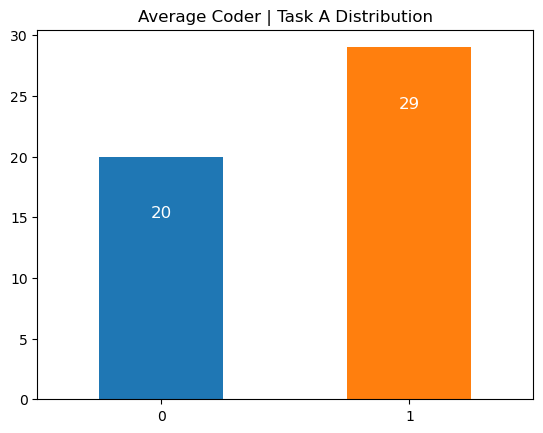

In [18]:
# Plotting : Average coder | Task A Distribution
plot = aug['avr_label_A'].value_counts().sort_index().plot(kind='bar', title='Average Coder | Task A Distribution', rot=0, color=colors)

i = 0
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() - 5
    plt.annotate(aug['avr_label_A'].value_counts()[i], xy = (x_value, y_value), ha='center', fontsize=12, color='white')
    i += 1

We will compare the distributions of the students' annotators through the difference between the mean values of the datasets.

In [19]:
# Calculation of students' annotation distribution disagreement with gold for task A
global_mean = aug['avr_label_A'].mean() # gold annotator task A mean

dA_acc = {}
for key, _ in acc.items():
    curr_mean = aug["{}_A".format(key)].mean() # mean for task A annotation of student
    diff_mean = abs(global_mean - curr_mean) # difference of mean value of student from gold
    dA_acc[key] = diff_mean

distribution_A = pd.DataFrame.from_dict(dA_acc, orient='index', columns=['dist_diff']).reset_index().rename(columns={'index': 'student'})
distribution_A.sort_values(by=['dist_diff'], ascending=False).head(5) # top 5

,student,dist_diff
0,f3352218,0.265306
3,f3352203,0.204082
8,f3352205,0.204082
5,f3352212,0.061224
1,f3352214,0.040816


The top 3 students' annotators that deviate the most from the average coder are ```f3352218```, ```f3352203```, ```f3352205```. For reference, we will visualize the distribution of the most different one:

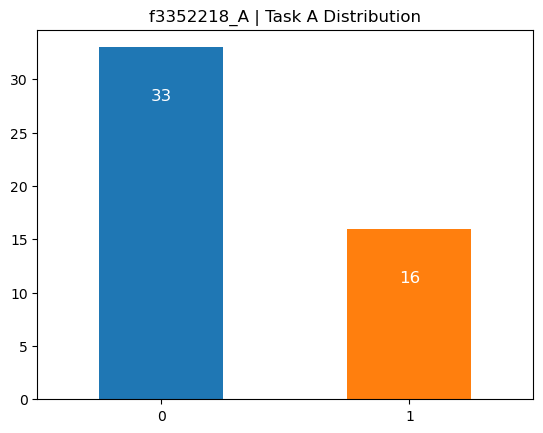

In [20]:
# Plotting : f3352218 | Task A Distribution
plot = aug['f3352218_A'].value_counts().sort_index().plot(kind='bar', title='f3352218_A | Task A Distribution', rot=0, color=colors)

i = 0
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() - 5
    plt.annotate(aug['f3352218_A'].value_counts()[i], xy = (x_value, y_value), ha='center', fontsize=12, color='white')
    i += 1

We move on to task B:

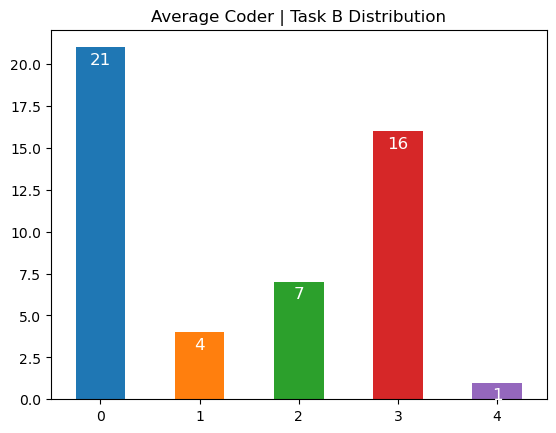

In [21]:
# Plotting : Average coder | Task B Distribution
plot = aug['avr_label_B'].value_counts().sort_index().plot(kind='bar', title='Average Coder | Task B Distribution', rot=0, color=colors)

i = 0
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() - 1
    plt.annotate(aug['avr_label_B'].value_counts()[i], xy = (x_value, y_value), ha='center', fontsize=12, color='white')
    i += 1

In [22]:
# Calculation of students' annotation distribution disagreement with gold for task B
global_mean = aug['avr_label_B'].mean() # gold annotator task B mean

dB_acc = {}
for key, _ in acc.items():
    curr_mean = aug["{}_B".format(key)].mean() # fetch mean for task B annotation of student
    diff_mean = abs(global_mean - curr_mean) # difference of mean value of student from gold
    dB_acc[key] = diff_mean

distribution_B = pd.DataFrame.from_dict(dB_acc, orient='index', columns=['dist_diff']).reset_index().rename(columns={'index': 'student'})
distribution_B.sort_values(by=['dist_diff'], ascending=False).head(5) # top 5

,student,dist_diff
0,f3352218,0.612245
4,f3352215,0.551020
8,f3352205,0.489796
1,f3352214,0.367347
7,f3352209,0.346939


The top 3 students' annotators that deviate the most from the average coder are ```f3352218```, ```f3352215```, ```f3352205```. For reference, we will visualize the distribution of the most different one:

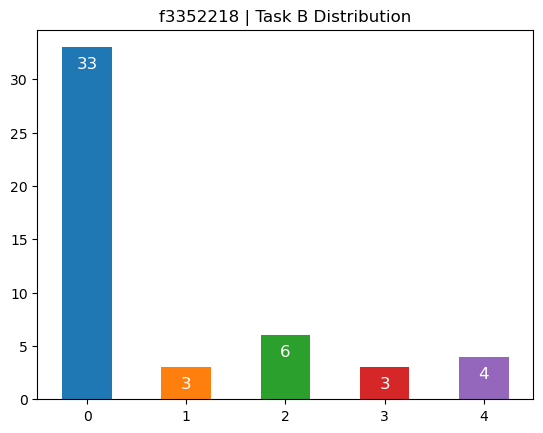

In [23]:
# Plotting : f3352218 | Task B Distribution
plot = aug['f3352218_B'].value_counts().sort_index().plot(kind='bar', title='f3352218 | Task B Distribution', rot=0, color=colors)

i = 0
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() - 2
    plt.annotate(aug['f3352218_B'].value_counts()[i], xy = (x_value, y_value), ha='center', fontsize=12, color='white')
    i += 1

### 2.
We will then locate the comments that annotators agree and disagree more with the gold annotator. We will do so by calculating the number of disagreeing annotators for every text.

In [24]:
# Texts that annotators agree/disagree the most
aug_v2 = aug.copy()
aug_v2 = aug_v2[aug_v2.columns[~aug_v2.columns.str.contains('B') & ~aug_v2.columns.isin(['avr_label_A'])]] # keep only students' annotations for task A
# if external = 1 then subtract row sum from 15 to find count of disagreements, if external = 0 then the row sum is the count of disagreements
aug_v2['disagreements'] = abs(15 * aug_v2['label'] - aug_v2[aug_v2.columns[aug_v2.columns.str.contains('A')]].sum(axis=1)) # sum in context of row
aug_v2[['text', 'label', 'disagreements']].sort_values(by=['disagreements'])

,text,label,disagreements
18,I just happen not to support modern feminism,0,0
34,They're all whores.,1,0
28,She's an evil bitch who deserves whatever she ...,1,0
26,"Military wives are often cheating, mooching bi...",1,0
47,"who knows if the charges will stick, and if th...",0,0
40,Whores spread disease and need money. Just ano...,1,0
22,Just a bunch of lying bitches. Me too is a jok...,1,0
21,It's not worth a false rape allegation. Better...,1,0
19,If she banged a random dude after an hour thou...,1,0
17,I don’t see how this is relevant to men’s rights.,0,0


We notice that there are 20 comments for which the annotators fully agree with the gold annotations. The texts for which the set of annotators disagree the most are 2 and consist of 4 disagreements in total.

### 3.
To select the most reliable coders, we are going to check the disagreement dataframe:

In [25]:
top_coders = agr.sort_values(by=['agreement'], ascending=False).head(5)
top_coders

,annotator,agreement,kappa
2,f3352202,1.000000,1.000000
6,f3342208,1.000000,1.000000
14,f3352201,1.000000,1.000000
9,f3352213,0.979592,0.958084
1,f3352214,0.959184,0.914186


In [26]:
final = pd.DataFrame()
for student in top_coders['annotator'].tolist():
    curr = acc[student]
    curr = curr[curr['source'] != 'external'] # discard external sources
    final = pd.concat([final, curr])
final = final.drop_duplicates(subset=['text']) # drop duplicate texts
final.head()

,text,source,A,B
49,Stop dating fatties,reddit,1,1
50,Journalist they are not. Agents in a corporate...,gab,0,0
51,"Iran Uranium Stockpile Soars to 950 Tons, Nucl...",gab,0,0
52,This is excellent from [USER] [URL],gab,0,0
53,That's Führerious.,gab,0,0


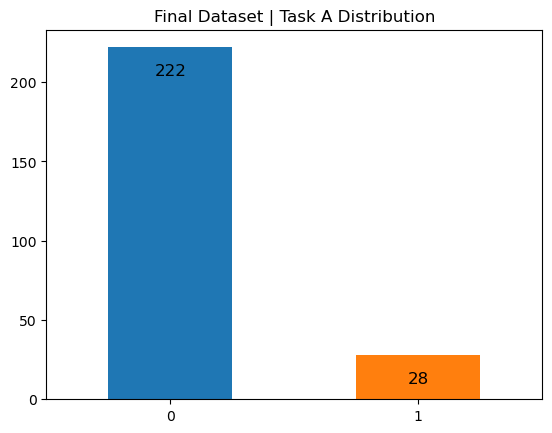

In [27]:
# Plotting : Final Dataset | Task A Distribution
plot = final['A'].value_counts().sort_index().plot(kind='bar', title='Final Dataset | Task A Distribution', rot=0, color=colors)

i = 0
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() - 18
    plt.annotate(final['A'].value_counts()[i], xy = (x_value, y_value), ha='center', fontsize=12, color='black')
    i += 1

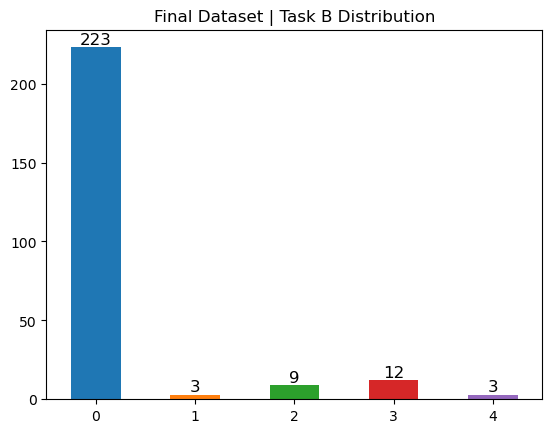

In [28]:
# Plotting : Final Dataset | Task B Distribution
plot = final['B'].value_counts().sort_index().plot(kind='bar', title='Final Dataset | Task B Distribution', rot=0, color=colors)

i = 0
for rect in plot.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height() + 2
    plt.annotate(final['B'].value_counts()[i], xy = (x_value, y_value), ha='center', fontsize=12, color='black')
    i += 1

In [29]:
final.to_csv('./3352209_final.csv', index=False)